In [4]:
import pandas as pd
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import gffutils

### Notes
- analyze syntelog counts overall with information about sequence length difference and mulitmapping ratio

In [5]:
# pivot the allele table
# 1. read the allele table
df = pd.read_csv('/scratch/nadjafn/Atlantic_ASE/output/AlleleFinder/allelefinder/allele.adjusted.txt', sep='\t')
# select the rows that have exactly one entry in 'A', 'B', 'C', 'D' columns. so no , and no missing values
df = df[(df['Allele A'].str.count(',') == 0) & (df['Allele B'].str.count(',') == 0) & (df['Allele C'].str.count(',') == 0) & (df['Allele D'].str.count(',') == 0)]
# reset the index
df = df.reset_index(drop=True)
# Add a id column to the dataframe
df['Synt_id'] = df.index
# 2. pivot the table so that each row is a single allele
# 2.1. select the columns that we want to pivot
df_synt = df[['Synt_id', 'Allele A', 'Allele B', 'Allele C', 'Allele D']]
# 2.2. rename the columns
df_synt.columns = ['Synt_id', '1', '2', '3', '4']
# 2.3. melt the table
df_synt = pd.melt(df_synt, id_vars=['Synt_id'], value_vars=['1', '2', '3', '4'], var_name='haplotype', value_name='haplotype_id')

In [6]:
print(df_synt[df_synt['Synt_id'] == 261])

       Synt_id haplotype                                       haplotype_id
261        261         1  Synt_240_chr01_1G_x5|hap1_Soltu.DM.01G003360.1...
12501      261         2  Synt_240_chr01_2G_x5|hap2_Soltu.DM.01G003360.1...
24741      261         3  Synt_240_chr01_3G_x5|hap3_Soltu.DM.01G003360.1...
36981      261         4  Synt_240_chr01_4G_x5|hap4_Soltu.DM.01G003360.1...


In [7]:
# print the info for 

### Plot the length difference per synt group

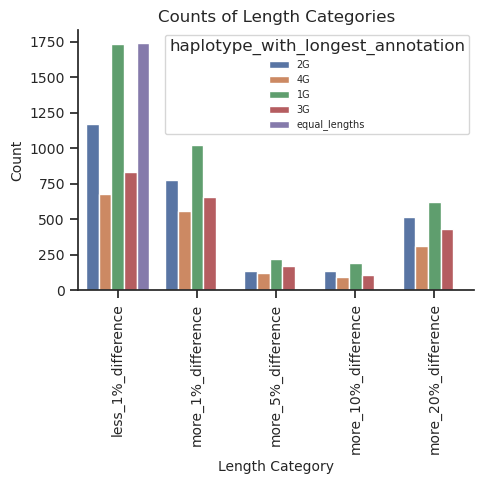

In [42]:
#ref_lengths = get_transcript_lengths('/scratch/nadjafn/Atlantic_ASE/output/liftoff_syntelogs_v6/updated_v62Atl_liftoff_a0.9s0.9_ALL.gff')
ref_lengths['haplotype_id'] = ref_lengths.index
# Merge the two dataframes
df_synt_lengths = pd.merge(df_synt, ref_lengths, on='haplotype_id', how='inner')
# group the haplotypes ids by synteny id
#df_synt_lengths
haplotype_ids = df_synt_lengths.groupby(['Synt_id'])['haplotype_id'].sum().reset_index()
df_synt_pivot = df_synt_lengths.pivot(index='Synt_id', columns=['haplotype'], values='ref_length')
df_synt_pivot = pd.merge(df_synt_pivot, haplotype_ids, on='Synt_id', how='inner')
# drop the synteny id column
df_synt_pivot.index = df_synt_pivot['Synt_id']
df_synt_pivot = df_synt_pivot.drop(columns=['Synt_id'])
# rename the columns
df_synt_pivot
df_synt_pivot.columns = ['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G', 'haplotype_id']
df_length = add_length_category(df_synt_pivot)
df_length_cat = add_longest_transcript(df_length)
make_barplot(df_length_cat)

In [43]:
df_length_cat 


,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
Synt_id,,,,,,,
0,837,837,837,837,Synt_1744_chr01_1G_x4|Soltu.Atl_v3.01_1G016780...,less_1%_difference,equal_lengths
1,761,763,777,777,Synt_1970_chr01_1G_x4|Soltu.Atl_v3.01_1G018980...,more_1%_difference,3G
2,658,553,553,652,Synt_20601_chr08_1G_x8|hap1_Soltu.DM.10G009940...,more_10%_difference,1G
3,749,749,414,414,Synt_2300_chr01_1G_x4|Soltu.Atl_v3.01_1G022210...,more_20%_difference,1G
4,390,360,354,360,Synt_2499_chr01_1G_x4|Soltu.Atl_v3.01_1G023000...,more_10%_difference,1G
...,...,...,...,...,...,...,...
12235,1611,1139,1139,1609,Synt_30371_chr12_1G_x3|hap1_Soltu.DM.12G029240...,more_20%_difference,1G
12236,7337,6786,6786,7377,Synt_30374_chr12_1G_x3|hap1_Soltu.DM.12G029300...,more_5%_difference,4G
12237,1040,134,117,1055,Synt_30379_chr12_1G_x3|hap1_Soltu.DM.12G029370...,more_20%_difference,4G


### Read in counts 

In [44]:
counts = pd.read_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/03_GENECOUNTS/merged_counts_filtered.tsv', sep='\t')
counts = sum_sample_counts(counts)
# change tname to haplotype_id
# merge the counts with the allele table
df = df_synt.merge(counts, left_on='haplotype_id', right_on='tname')
df_pivot = df.pivot(index='Synt_id', columns='haplotype', values='num_reads')
# show only lines that have counts
df_pivot = df_pivot.loc[df_pivot.sum(axis=1) >= 20]
df_pivot
print(df_pivot.loc[429])

haplotype
1    66.0
2    61.0
3    65.0
4    50.0
Name: 429, dtype: float64


In [ ]:
counts = pd.read_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/03_GENECOUNTS/merged_counts.tsv', sep='\t')
counts = sum_sample_counts(counts)
# change tname to haplotype_id
# merge the counts with the allele table
df = df_synt.merge(counts, left_on='haplotype_id', right_on='tname')
df_pivot = df.pivot(index='Synt_id', columns='haplotype', values='num_reads')
# show only lines that have counts
df_pivot = df_pivot.loc[df_pivot.sum(axis=1) >= 20]
# print where synt id is  429
print(df_pivot.loc[429])
df


haplotype
1     NaN
2    60.0
3     NaN
4     NaN
Name: 429, dtype: float64


,Synt_id,haplotype,haplotype_id,tname,SRR14993892_leaf,SRR14993893_leaf,SRR14993894_leaf,SRR14993895_leaf,SRR14995031_tuber,SRR14995032_tuber,SRR14995033_tuber,SRR14995034_tuber,SRR14995933_tuber,SRR14996168_leaf,num_reads
0,14,1,no_syntelog_chr01_1G_x|Soltu.Atl_v3.01_1G00198...,no_syntelog_chr01_1G_x|Soltu.Atl_v3.01_1G00198...,NaN,NaN,2.0,1.0,NaN,NaN,2.0,1.0,1.0,2.0,9.0
1,26,1,no_syntelog_chr01_1G_x|hap1_Soltu.DM.04G015380...,no_syntelog_chr01_1G_x|hap1_Soltu.DM.04G015380...,2.0,1.0,4.0,1.0,6.0,NaN,NaN,1.0,3.0,NaN,18.0
2,38,1,no_syntelog_chr09_1G_x|hap1_Soltu.DM.03G006900...,no_syntelog_chr09_1G_x|hap1_Soltu.DM.03G006900...,1.0,2.0,49.0,12.0,118.0,4.0,5.0,1.0,1.0,6.0,199.0
3,42,1,no_syntelog_chr11_1G_x|hap1_Soltu.DM.08G027460...,no_syntelog_chr11_1G_x|hap1_Soltu.DM.08G027460...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,44,1,Synt_1_chr01_1G_x3|hap1_Soltu.DM.01G000010.4|S...,Synt_1_chr01_1G_x3|hap1_Soltu.DM.01G000010.4|S...,5.0,6.0,47.0,18.0,9.0,8.0,9.0,7.0,11.0,27.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28385,12232,4,no_syntelog_chr12_4G_x|hap4_Soltu.DM.12G029210...,no_syntelog_chr12_4G_x|hap4_Soltu.DM.12G029210...,15.0,13.0,78.0,35.0,30.0,14.0,52.0,21.0,21.0,67.0,346.0
28386,12234,4,Synt_30370_chr12_4G_x4|hap4_Soltu.DM.12G029230...,Synt_30370_chr12_4G_x4|hap4_Soltu.DM.12G029230...,NaN,1.0,3.0,2.0,1.0,NaN,NaN,1.0,NaN,2.0,10.0
28387,12235,4,Synt_30371_chr12_4G_x3|hap4_Soltu.DM.12G029240...,Synt_30371_chr12_4G_x3|hap4_Soltu.DM.12G029240...,4.0,NaN,11.0,7.0,1.0,NaN,NaN,NaN,1.0,5.0,29.0
28388,12236,4,no_syntelog_chr12_4G_x|hap4_Soltu.DM.12G029300...,no_syntelog_chr12_4G_x|hap4_Soltu.DM.12G029300...,NaN,NaN,2.0,NaN,5.0,NaN,2.0,3.0,4.0,NaN,16.0


### Get the multimapping counts

Synt_id
10       0.977778
14       0.076923
16       0.933333
17       0.000000
23       0.000000
           ...   
12234    0.798507
12235    0.327586
12236    0.702703
12237    0.047945
12238    0.093996
Name: multi_ratio, Length: 10254, dtype: float64


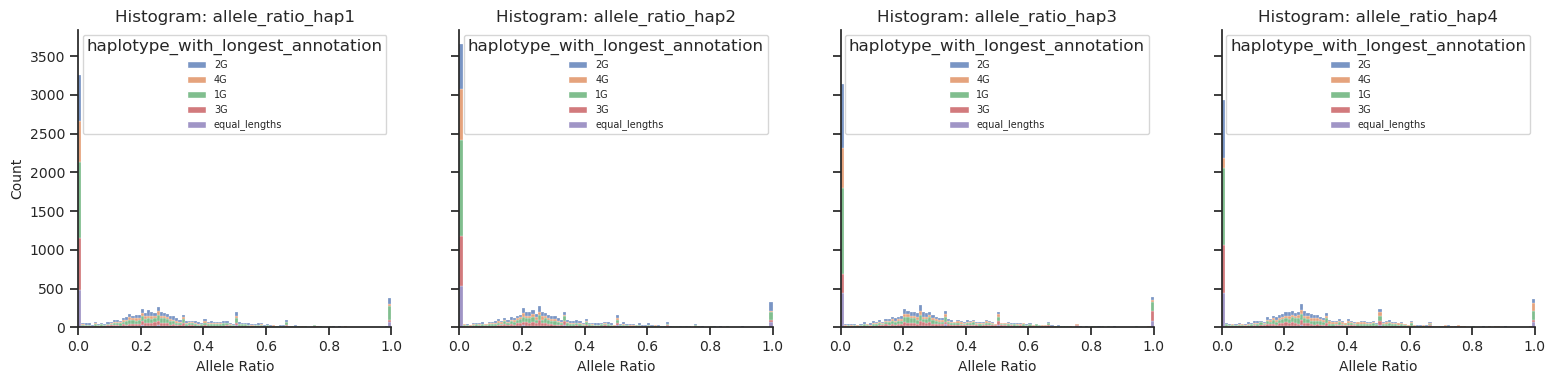

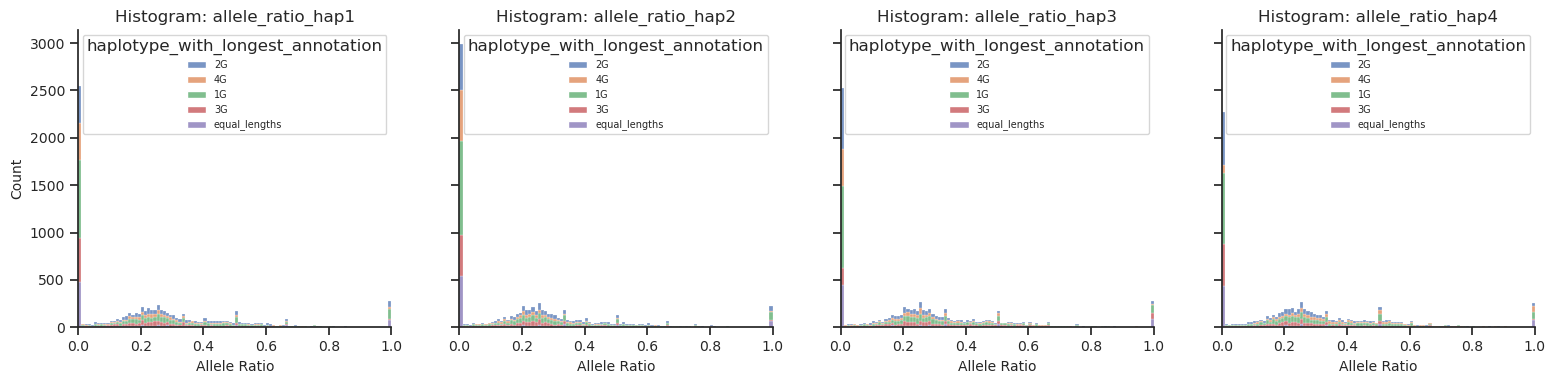

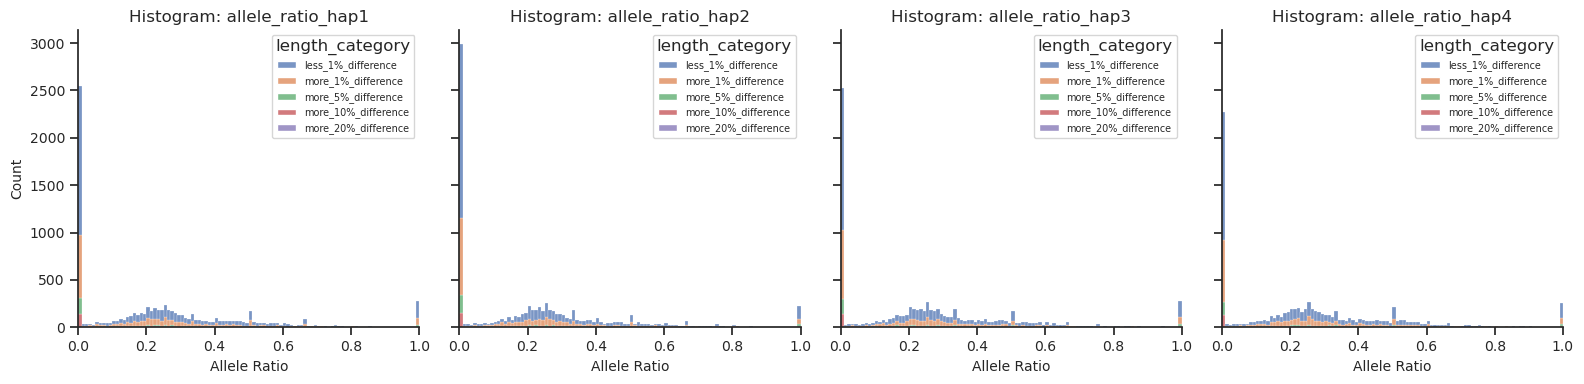

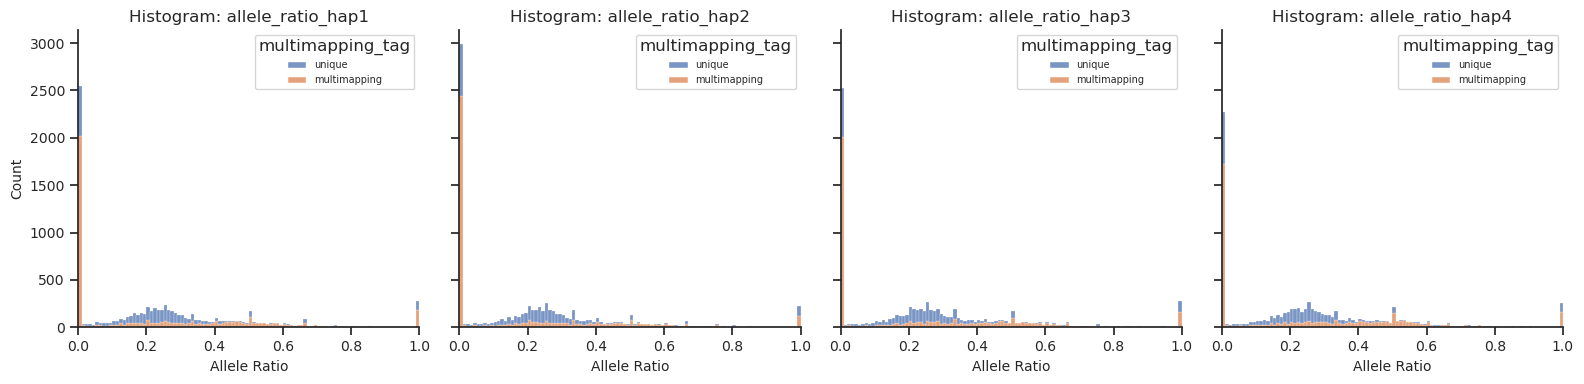

filter synts with high mulit mapping ratio


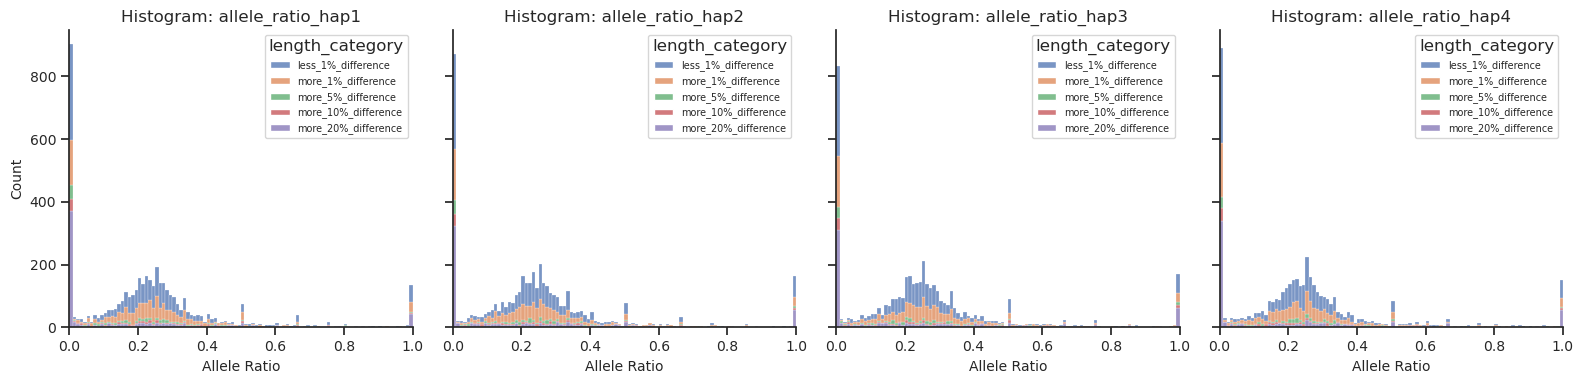

filter synts with > 20% difference in length


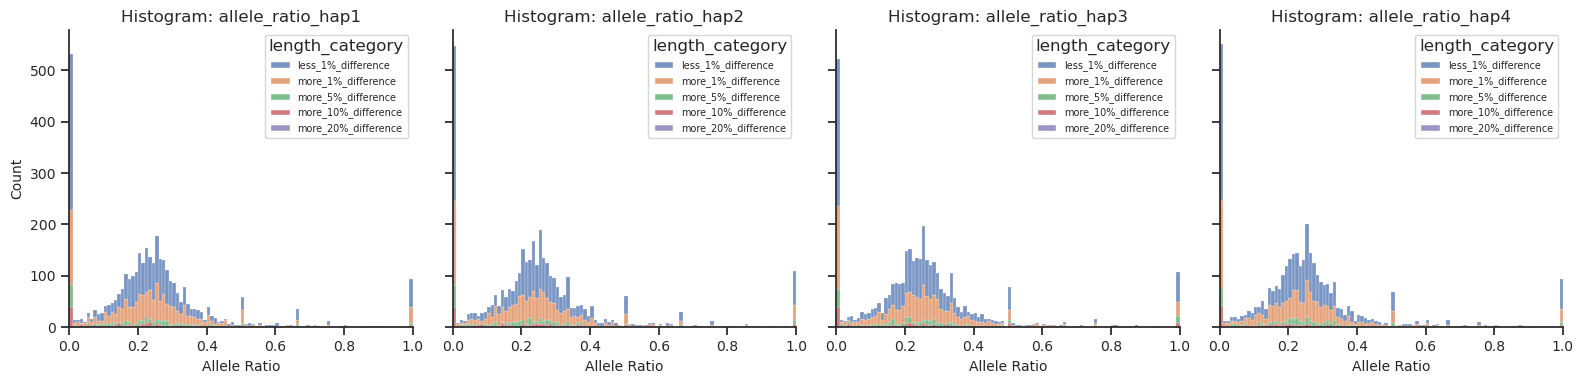

In [75]:
multi_counts = counts[counts['tname'].str.contains('&')]
# split the tname column by '&'
multi_counts['tname'] = multi_counts['tname'].str.split('&')
# explode the list
multi_counts_exp = multi_counts.explode('tname', ignore_index=True)
multi_counts_exp = multi_counts_exp.groupby('tname').sum()
# join with the synteny table
multi_counts = multi_counts_exp.merge(df_synt, left_on='tname', right_on='haplotype_id')
multi_counts = multi_counts.groupby('Synt_id').sum()
# rename the num_reads column to num_reads_multi
multi_counts = multi_counts.rename(columns={'num_reads': 'num_reads_multi'})
# drop the columns beside the num_reads_multi
multi_counts = multi_counts['num_reads_multi']
# merge the multi_counts with the df_pivot
df_pivot_multi = df_pivot.merge(multi_counts, on='Synt_id', how='left')
# add muliti ratio
# fill NaN values with 0
df_pivot_multi = df_pivot_multi.fillna(0)
df_pivot_multi['multi_ratio'] = df_pivot_multi['num_reads_multi'] / (df_pivot_multi['1'] + df_pivot_multi['2'] + df_pivot_multi['3'] + df_pivot_multi['4'] + df_pivot_multi['num_reads_multi'])
# Print the multi_ratio for Synt_id = 429
print(df_pivot_multi['multi_ratio'])
df_pivot_multi = get_allele_ratio(df_pivot_multi)
df_pivot_multi['multimapping_tag'] = np.where(df_pivot_multi['multi_ratio'] > 0.25, 'multimapping', 'unique')
# add the length categories
df_pivot_multi_with_cat = df_pivot_multi.merge(df_length_cat, on='Synt_id')
# save the file
df_pivot_multi_with_cat.to_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_with_info.tsv', sep='\t')
plot_hist(df_pivot_multi_with_cat, 'haplotype_with_longest_annotation')
# filter to exlude rows with mapping category 'more_20%_difference'
df_pivot_multi_with_cat_filt = df_pivot_multi_with_cat[df_pivot_multi_with_cat['length_category'] != 'more_20%_difference']
plot_hist(df_pivot_multi_with_cat_filt, 'haplotype_with_longest_annotation')
plot_hist(df_pivot_multi_with_cat_filt, 'length_category')
plot_hist(df_pivot_multi_with_cat_filt, 'multimapping_tag')
# filter to only include rows with mapping category 'unique'
df_pivot_multi_with_cat_uniq = df_pivot_multi_with_cat[df_pivot_multi_with_cat['multimapping_tag'] == 'unique']
print("filter synts with high mulit mapping ratio")
plot_hist(df_pivot_multi_with_cat_uniq, 'length_category')
print("filter synts with > 20% difference in length")
df_pivot_multi_with_cat_uniq_filt = df_pivot_multi_with_cat_uniq[df_pivot_multi_with_cat_uniq['length_category'] != 'more_20%_difference']
plot_hist(df_pivot_multi_with_cat_uniq_filt, 'length_category')

In [56]:
df_pivot_multi_with_cat

,1,2,3,4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
Synt_id,,,,,,,,,,,,,,,,,,
14,9.0,12.0,28.0,11.0,5.0,0.076923,0.150000,0.200000,0.466667,0.183333,unique,291,243,266,288,no_syntelog_chr01_1G_x|Soltu.Atl_v3.01_1G00198...,more_10%_difference,1G
24,0.0,0.0,101.0,30.0,366.0,0.736419,0.000000,0.000000,0.770992,0.229008,multimapping,582,582,543,542,no_syntelog_chr01_1G_x|Soltu.Atl_v3.01_1G03213...,more_5%_difference,1G
26,18.0,0.0,0.0,2.0,0.0,0.000000,0.900000,0.000000,0.000000,0.100000,unique,995,567,594,555,no_syntelog_chr01_1G_x|hap1_Soltu.DM.04G015380...,more_20%_difference,1G
38,199.0,293.0,1785.0,1.0,4965.0,0.685489,0.087357,0.128622,0.783582,0.000439,multimapping,204,204,204,203,no_syntelog_chr09_1G_x|hap1_Soltu.DM.03G006900...,less_1%_difference,1G
44,147.0,198.0,108.0,190.0,228.0,0.261768,0.228616,0.307932,0.167963,0.295490,multimapping,1836,1873,1581,1867,Synt_1_chr01_1G_x3|hap1_Soltu.DM.01G000010.4|S...,more_10%_difference,2G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12234,17.0,0.0,0.0,10.0,107.0,0.798507,0.629630,0.000000,0.000000,0.370370,multimapping,1806,1793,1793,1834,Synt_30370_chr12_1G_x4|hap1_Soltu.DM.12G029230...,more_1%_difference,4G
12235,10.0,0.0,0.0,29.0,19.0,0.327586,0.256410,0.000000,0.000000,0.743590,multimapping,1611,1139,1139,1609,Synt_30371_chr12_1G_x3|hap1_Soltu.DM.12G029240...,more_20%_difference,1G
12236,6.0,0.0,0.0,16.0,52.0,0.702703,0.272727,0.000000,0.000000,0.727273,multimapping,7337,6786,6786,7377,Synt_30374_chr12_1G_x3|hap1_Soltu.DM.12G029300...,more_5%_difference,4G


In [13]:
counts = pd.read_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/03_GENECOUNTS/merged_counts.tsv', sep='\t')


In [72]:
counts = pd.read_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/03_GENECOUNTS/merged_counts.tsv', sep='\t')

# change tname to haplotype_id
# merge the counts with the allele table
df = df_synt.merge(counts, left_on='haplotype_id', right_on='tname')
# get the sample names columns
sample_columns = counts.columns[counts.columns.str.contains('leaf|tuber')]
# convert the sample columns to list
sample_columns = sample_columns.tolist()
sample_columns
df_pivot = df.pivot(index='Synt_id', columns='haplotype', values=sample_columns)
# drop the columns that have less than 20 reads
#df_pivot = df_pivot.loc[df_pivot.sum(axis=1) >= 50]
# faltten the columns
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
# get the Synts that have the same length

same_length_syntelogs = df_length_cat[df_length_cat['haplotype_with_longest_annotation'] == 'equal_lengths']
same_length_syntelogs['Synt_id'] = same_length_syntelogs.index

df_pivot.to_csv('/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_all.tsv', sep='\t')

In [73]:
df_pivot

,SRR14993892_leaf_1,SRR14993892_leaf_2,SRR14993892_leaf_3,SRR14993892_leaf_4,SRR14993893_leaf_1,SRR14993893_leaf_2,SRR14993893_leaf_3,SRR14993893_leaf_4,SRR14993894_leaf_1,SRR14993894_leaf_2,...,SRR14995034_tuber_3,SRR14995034_tuber_4,SRR14995933_tuber_1,SRR14995933_tuber_2,SRR14995933_tuber_3,SRR14995933_tuber_4,SRR14996168_leaf_1,SRR14996168_leaf_2,SRR14996168_leaf_3,SRR14996168_leaf_4
Synt_id,,,,,,,,,,,,,,,,,,,,,
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,1.0,2.0,NaN,1.0,NaN,NaN,2.0,1.0,...,NaN,2.0,1.0,1.0,4.0,3.0,2.0,1.0,5.0,NaN
16,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12234,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0
12235,1.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,5.0
12236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


# Functions


In [47]:
def check_length_values(row, percent):
    min_value = row.min()
    max_value = row.max()

    # Calculate the 1% range
    ten_percent = min_value * percent * 0.01

    # Check if all values are within 1% of each other
    return max_value >= min_value + ten_percent


def add_length_category(df):
    # Select only the relevant columns
    df_subset = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']]


    df_subset = df_subset.astype(int)

    # print max and min values of each row
    df['length_category'] = 'unclassified'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 0), axis=1), 'length_category'] = 'less_1%_difference'
    df.loc[df_subset.apply(lambda x: check_length_values(x, 1), axis=1), 'length_category'] = 'more_1%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 5), axis=1), 'length_category'] = 'more_5%_difference'

    df.loc[df_subset.apply(lambda x: check_length_values(x, 10), axis=1), 'length_category'] = 'more_10%_difference'


    df.loc[df_subset.apply(lambda x: check_length_values(x, 20), axis=1), 'length_category'] = 'more_20%_difference'
    return df

def add_longest_transcript(df):

    df['haplotype_with_longest_annotation'] = df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].idxmax(axis=1)
    mask = (df[['ref_length_1G', 'ref_length_2G', 'ref_length_3G', 'ref_length_4G']].nunique(axis=1) == 1)
    df.loc[mask, 'haplotype_with_longest_annotation'] = 'equal_lengths'
    df['haplotype_with_longest_annotation'] = df['haplotype_with_longest_annotation'].str.replace('ref_length_', '')
    #df.loc[df['length_category'] == 'less_1%_difference', 'haplotype_with_longest_annotation'] = 'lengths_within_5%'
    return df

def make_barplot(df):
    plt.figure(figsize=(5, 5))
    # Sort the DataFrame by the 'length_category' column
    custom_order = ['less_1%_difference','more_1%_difference', 'more_5%_difference', 'more_10%_difference', 'more_20%_difference']  # replace with your actual categories
    df['length_category'] = pd.Categorical(df['length_category'], categories=custom_order, ordered=True)
    # chagne the haplotype_with_longest_annotation to a categorical variable
    df['haplotype_with_longest_annotation'] = pd.Categorical(df['haplotype_with_longest_annotation'], categories=['2G', '4G', '1G', '3G', 'equal_lengths'], ordered=True)
    sns.countplot(x='length_category', hue='haplotype_with_longest_annotation', data=df)
    plt.xlabel('Length Category')
    plt.ylabel('Count')
    # turn the x-axis labels
    plt.xticks(rotation=90)
    plt.title('Counts of Length Categories')
    plt.tight_layout()
    # show the plot
    plt.show()

def get_transcript_lengths(gff_file):
    # Create a database from the GFF file
    db = gffutils.create_db(gff_file, dbfn='gff.db', force=True, keep_order=True,
                            merge_strategy='merge', sort_attribute_values=True)

    # Initialize an empty dictionary to store transcript lengths
    transcript_lengths = {}

    # Iterate over all features of type 'exon' in the GFF file
    for exon in db.features_of_type('exon'):

        parent_id = exon.attributes['Parent'][0]
        length = exon.end - exon.start + 1
        if parent_id not in transcript_lengths:
            transcript_lengths[parent_id] = 0

        transcript_lengths[parent_id] += length
    print(transcript_lengths)

    # Filter based on output_prefix if necessary

    #transcript_lengths = {k: v for k, v in transcript_lengths.items() if 'Synt' in k and 'x4' in k}


    # Create a DataFrame from the dictionary
    df = pd.DataFrame.from_dict(transcript_lengths, orient='index', columns=['ref_length'])
    return df

def get_multimapping_tags(df):
    # extract the tnames that contain "&"
    df = df[df['haplotype_id'].str.contains('&')]
    print(df)
    # rename num_reads to multimapping_reads
    df = df.rename(columns={'num_reads': 'multimapping_reads'})
    return df

def sum_sample_counts(df):
    # sum the counts for each sample and skip the first column
    df['num_reads'] = df.iloc[:, 1:].sum(axis=1)

    return df

pd.options.mode.chained_assignment = None

sns.set_theme(style='ticks', rc={
    'figure.figsize': (4, 4),  # figure size in inches
    'axes.labelsize': 10,           # font size of the x and y labels
    'xtick.labelsize': 10,          # font size of the tick labels
    'ytick.labelsize': 10,          # font size of the tick labels
    'legend.fontsize': 7,          # font size of the legend
    "axes.spines.right": False, 
    "axes.spines.top": False})



# Load input file
def load_input(input_file):
    return pd.read_csv(input_file, sep='\t')



def add_mulitmapping_ratio( df, multi):
    # join the two dataframes
    df = df.join(multi.set_index('Synt'), on='Synt')
    # calculate the ratio of multimapping reads vs total reads
    df['multimapping_ratio'] = df['multimapping_reads'] / (df['hap1'] + df['hap2'] + df['hap3'] +  df['hap4']+ df['multimapping_reads'])
    # add a tag if the multimapping ratio is above 0.25
    df['multimapping_tag'] = np.where(df['multimapping_ratio'] > 0.25, 'multimapping', 'unique')
    return df

def get_allele_ratio(df):
    # replace NaN with 0
    df = df.fillna(0)
    df['allele_ratio_hap1'] = df['1'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap2'] = df['2'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap3'] = df['3'] / (df['1'] + df['2'] + df['3'] + df['4'])
    df['allele_ratio_hap4'] = df['4'] / (df['1'] + df['2'] + df['3'] + df['4'])

    return df

def plot_hist(df, my_hue='multimapping_tag'):
    # Ensure NaN allele ratios are set to 0
    #df = df.fillna(0)
    
    # Identify haplotype columns dynamically
    hap_cols = [col for col in df.columns if col.startswith('allele_ratio_hap')]
    
    # Set up the plotting grid for side-by-side histograms
    fig, axes = plt.subplots(1, len(hap_cols), figsize=(4 * len(hap_cols), 4), sharey=True)

    # If there's only one haplotype column, axes won't be an array
    if len(hap_cols) == 1:
        axes = [axes]
    
    # Loop over haplotype columns and plot
    for ax, hap_col in zip(axes, hap_cols):
        sns.histplot(
            data=df,
            x=hap_col,
            bins=100,
            hue=my_hue,
            multiple='stack',
            ax=ax
        )
        ax.set_title(f'Histogram: {hap_col}')
        ax.set_xlim(0, 1)
        #ax.set_ylim(0, 300)
        ax.set_xlabel('Allele Ratio')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()